# ETL
    1. Get tickers from finviz
    2. Get historic data using yfinance
    3. Compute daily returns based on Adjusted close price

In [1]:
from finvizfinance.screener.overview import Overview
import yfinance as yf
import riskfolio as rp

In [2]:
overView = Overview()
overView.set_filter(signal="New High", filters_dict= {'Price': 'Over $15', 'Country':'USA', 'Market Cap.':'+Mid (over $2bln)'})
# overView.set_filter(signal="New High", filters_dict= {'Price': 'Over $15', 'Country':'USA'})
new_high_data = overView.screener_view()

d:\anaconda3\envs\quant-stack-bk\lib\site-packages\finvizfinance\screener\overview.py:203: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([df, pd.DataFrame(frame)], ignore_index=True)


In [3]:
tickers = new_high_data.Ticker.to_list()
tickers.sort()

In [4]:
historic_ticker_data = yf.download(tickers=tickers, start = '2020-01-01', end = '2023-10-31')
historic_ticker_data = historic_ticker_data.loc[:,('Adj Close', slice(None))]
historic_ticker_data.columns = tickers

[*********************100%%**********************]  108 of 108 completed


In [5]:
daily_returns = historic_ticker_data[tickers].pct_change().dropna()

## Risk Analysis

In [6]:
portfolio = rp.Portfolio(returns=daily_returns)

In [7]:
# Define params for risk parity optimizer
portfolio.lowerret = 0.0008
portfolio.assets_stats(method_mu="hist", method_cov="hist", d=0.94)
w_rp = portfolio.rp_optimization(model="Classic", rm="MV", rf=0.05, hist=True)

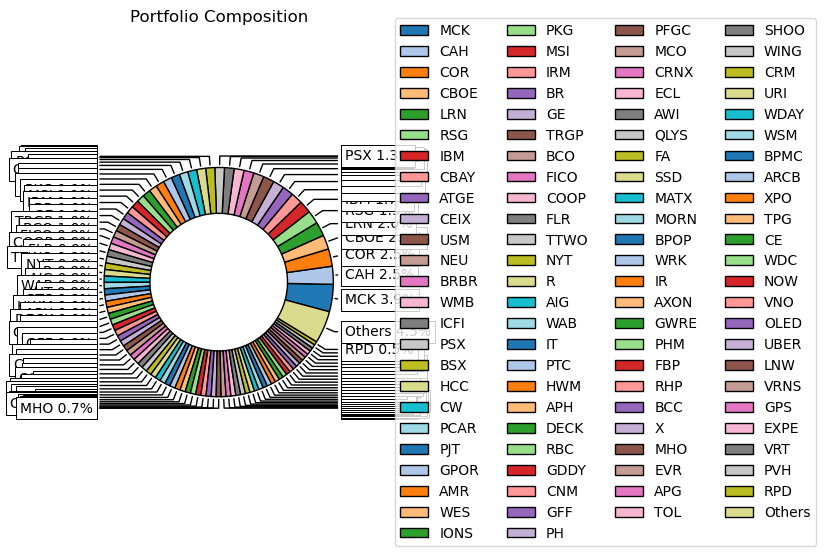

In [8]:
pie = rp.plot_pie(
    w=w_rp
)

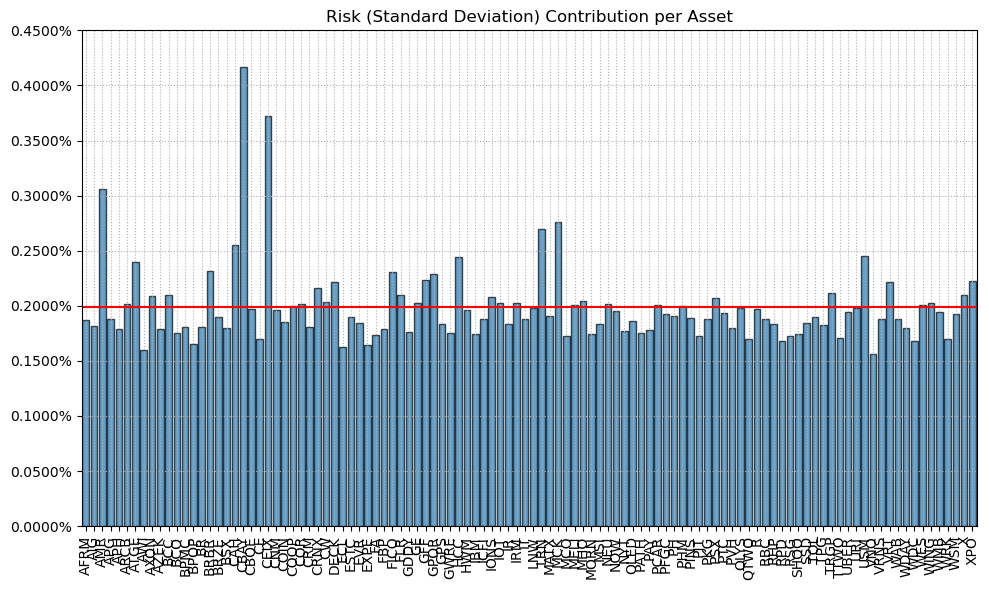

In [9]:
ax = rp.plot_risk_con(
    w=w_rp,
    cov= portfolio.cov,
    returns= portfolio.returns,
    rm="MV",
    rf=0.05
)

In [10]:
portfolio_value = 100_000

In [11]:
w_rp['investment_amount'] = w_rp * portfolio_value # weight * Market Value

In [12]:
w_rp['last_price'] = historic_ticker_data.iloc[-1]

In [13]:
w_rp['shares'] = round(w_rp.investment_amount / w_rp.last_price)

w_rp

,weights,investment_amount,last_price,shares
AFRM,0.002350,235.000619,17.100000,14.0
AIG,0.008968,896.783746,61.000000,15.0
AMR,0.011941,1194.123412,221.247330,5.0
APG,0.006853,685.329915,25.719999,27.0
APH,0.008611,861.098918,79.980003,11.0
...,...,...,...,...
WMB,0.014038,1403.753976,34.230000,41.0
WRK,0.007606,760.639361,35.150436,22.0
WSM,0.006439,643.904357,148.220001,4.0
X,0.007020,701.963381,33.820541,21.0


In [ ]:
(w_rp['shares'] * w_rp['last_price']).sum()

# IBroker automation
    Note: Should have IBroker client up and running for this to work

In [ ]:
from ibapi.client import EClient
from ibapi.wrapper import EWrapper
from ibapi.contract import Contract
from ibapi.order import *

import time
import threading

In [ ]:
class IBapi(EWrapper, EClient):
    def __init__(self):
        EClient.__init__(self, self)
    
    def nextValidId(self, orderId: int):
        super().nextValidId(orderId)
        self.nextOrderId = orderId
    

In [ ]:
def stock_contract(symbol, secType="STK", exchange="SMART", currency="USD"):
    contract = Contract()
    contract.symbol = symbol
    contract.secType = secType
    contract.exchange = exchange
    contract.currency = currency
    return contract


def submit_order(contract, direction, qty=100, orderType="MKT", transmit=True):
    order = Order()
    order.action = direction
    order.totalQuantity = qty
    order.orderType = orderType
    order.transmit = transmit
    order.eTradeOnly = ""
    order.firmQuoteOnly = ""
    # submit order
    app.placeOrder(app.nextOrderId, contract, order)
    app.nextOrderId += 1

In [ ]:
def run_loop():
    app.run()

app = IBapi()
app.connect('127.0.0.1', 7497, 123) # verify this on ibroker client
app.nextOrderId = None

api_thread = threading.Thread(target=run_loop, daemon=True)
api_thread.start()

while True:
    if isinstance(app.nextOrderId, int):
        print("Connected")
        break
    else:
        print("Waiting")
        time.sleep(1)

In [ ]:
for row in w_rp.itertuples():
    contract = stock_contract(row.Index)
    submit_order(contract, direction="BUY", qty=row.shares)